In [21]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy             as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

from numpy.fft    import fft, ifft, fftfreq
from numpy.random import normal
from random       import choice
from math         import ceil

import sys
np.set_printoptions(threshold=sys.maxsize)

In [22]:
Fs = 22050
Ts = 1/Fs

A = 1
K = 15
W = 2000

BITS_PER_BYTE    = 8
NUMBERS_OF_BYTES = 10
NUMBER_OF_BITS   = NUMBERS_OF_BYTES * BITS_PER_BYTE
SIGNAL_LENGTH    = NUMBER_OF_BITS * K

FREQUENCY_1 = 2000
FREQUENCY_2 = 4000
FREQUENCY_3 = 6000
FREQUENCY_4 = 8000

t = np.linspace(0, Ts*NUMBER_OF_BITS, SIGNAL_LENGTH)
f = fftfreq(SIGNAL_LENGTH, Ts)
bits = [A if b else -A for b in [choice([True, False]) for _ in range(NUMBER_OF_BITS)]]

def passband_filter(frequencies, omega, width):
    filter = np.zeros(frequencies.size)
    for i in np.argwhere(abs(abs(frequencies)-omega) <= width/2):
        filter[i] = 1
    return filter

def decoder(signal_input):
    signal_output = []
    
    for i in range(NUMBER_OF_BITS):
        acc = 0
        for j in range(K):
            acc += signal_input[i * K + j]
        signal_output.append(acc//K)
        
    return signal_output

def cos_modulator(omega):
    return np.array([np.cos(2*np.pi*omega*a*Ts) for a in range(SIGNAL_LENGTH)])

def modulator():
    return (cos_modulator(FREQUENCY_1) + \
            cos_modulator(FREQUENCY_2) + \
            cos_modulator(FREQUENCY_3) + \
            cos_modulator(FREQUENCY_4)) / 4

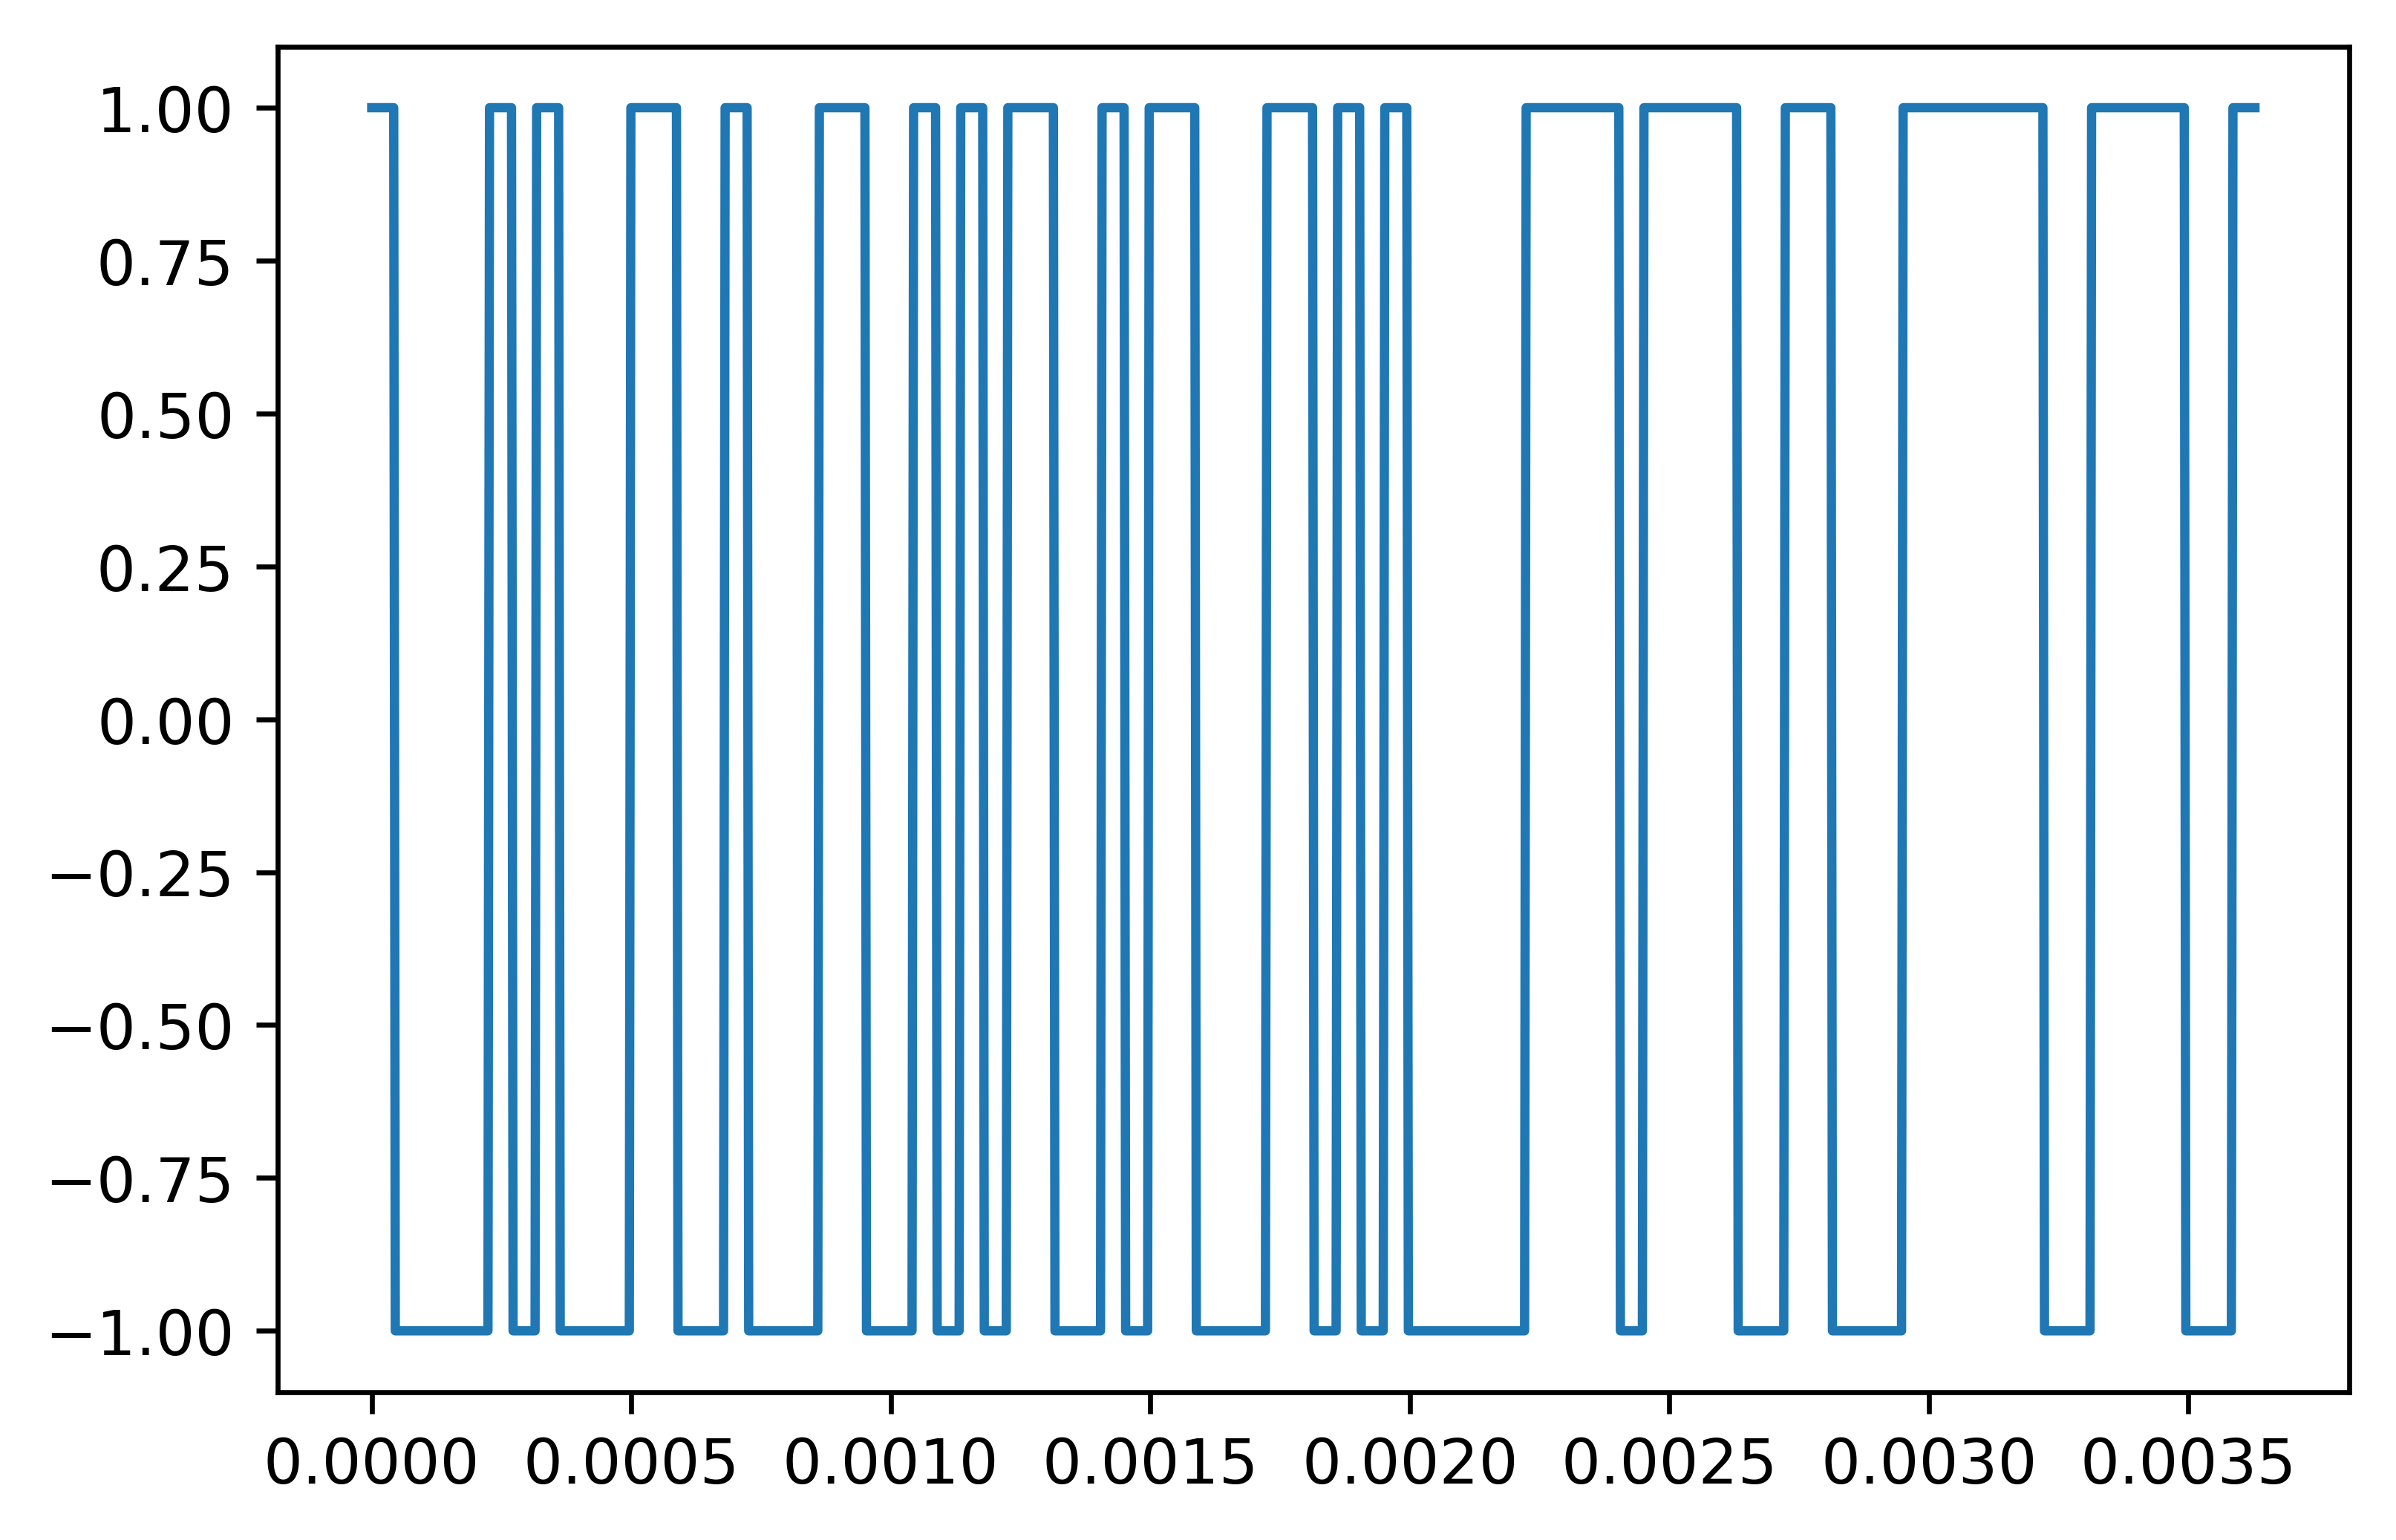

In [23]:
signal = np.repeat(bits, K)
plt.plot(t, signal)
plt.show()

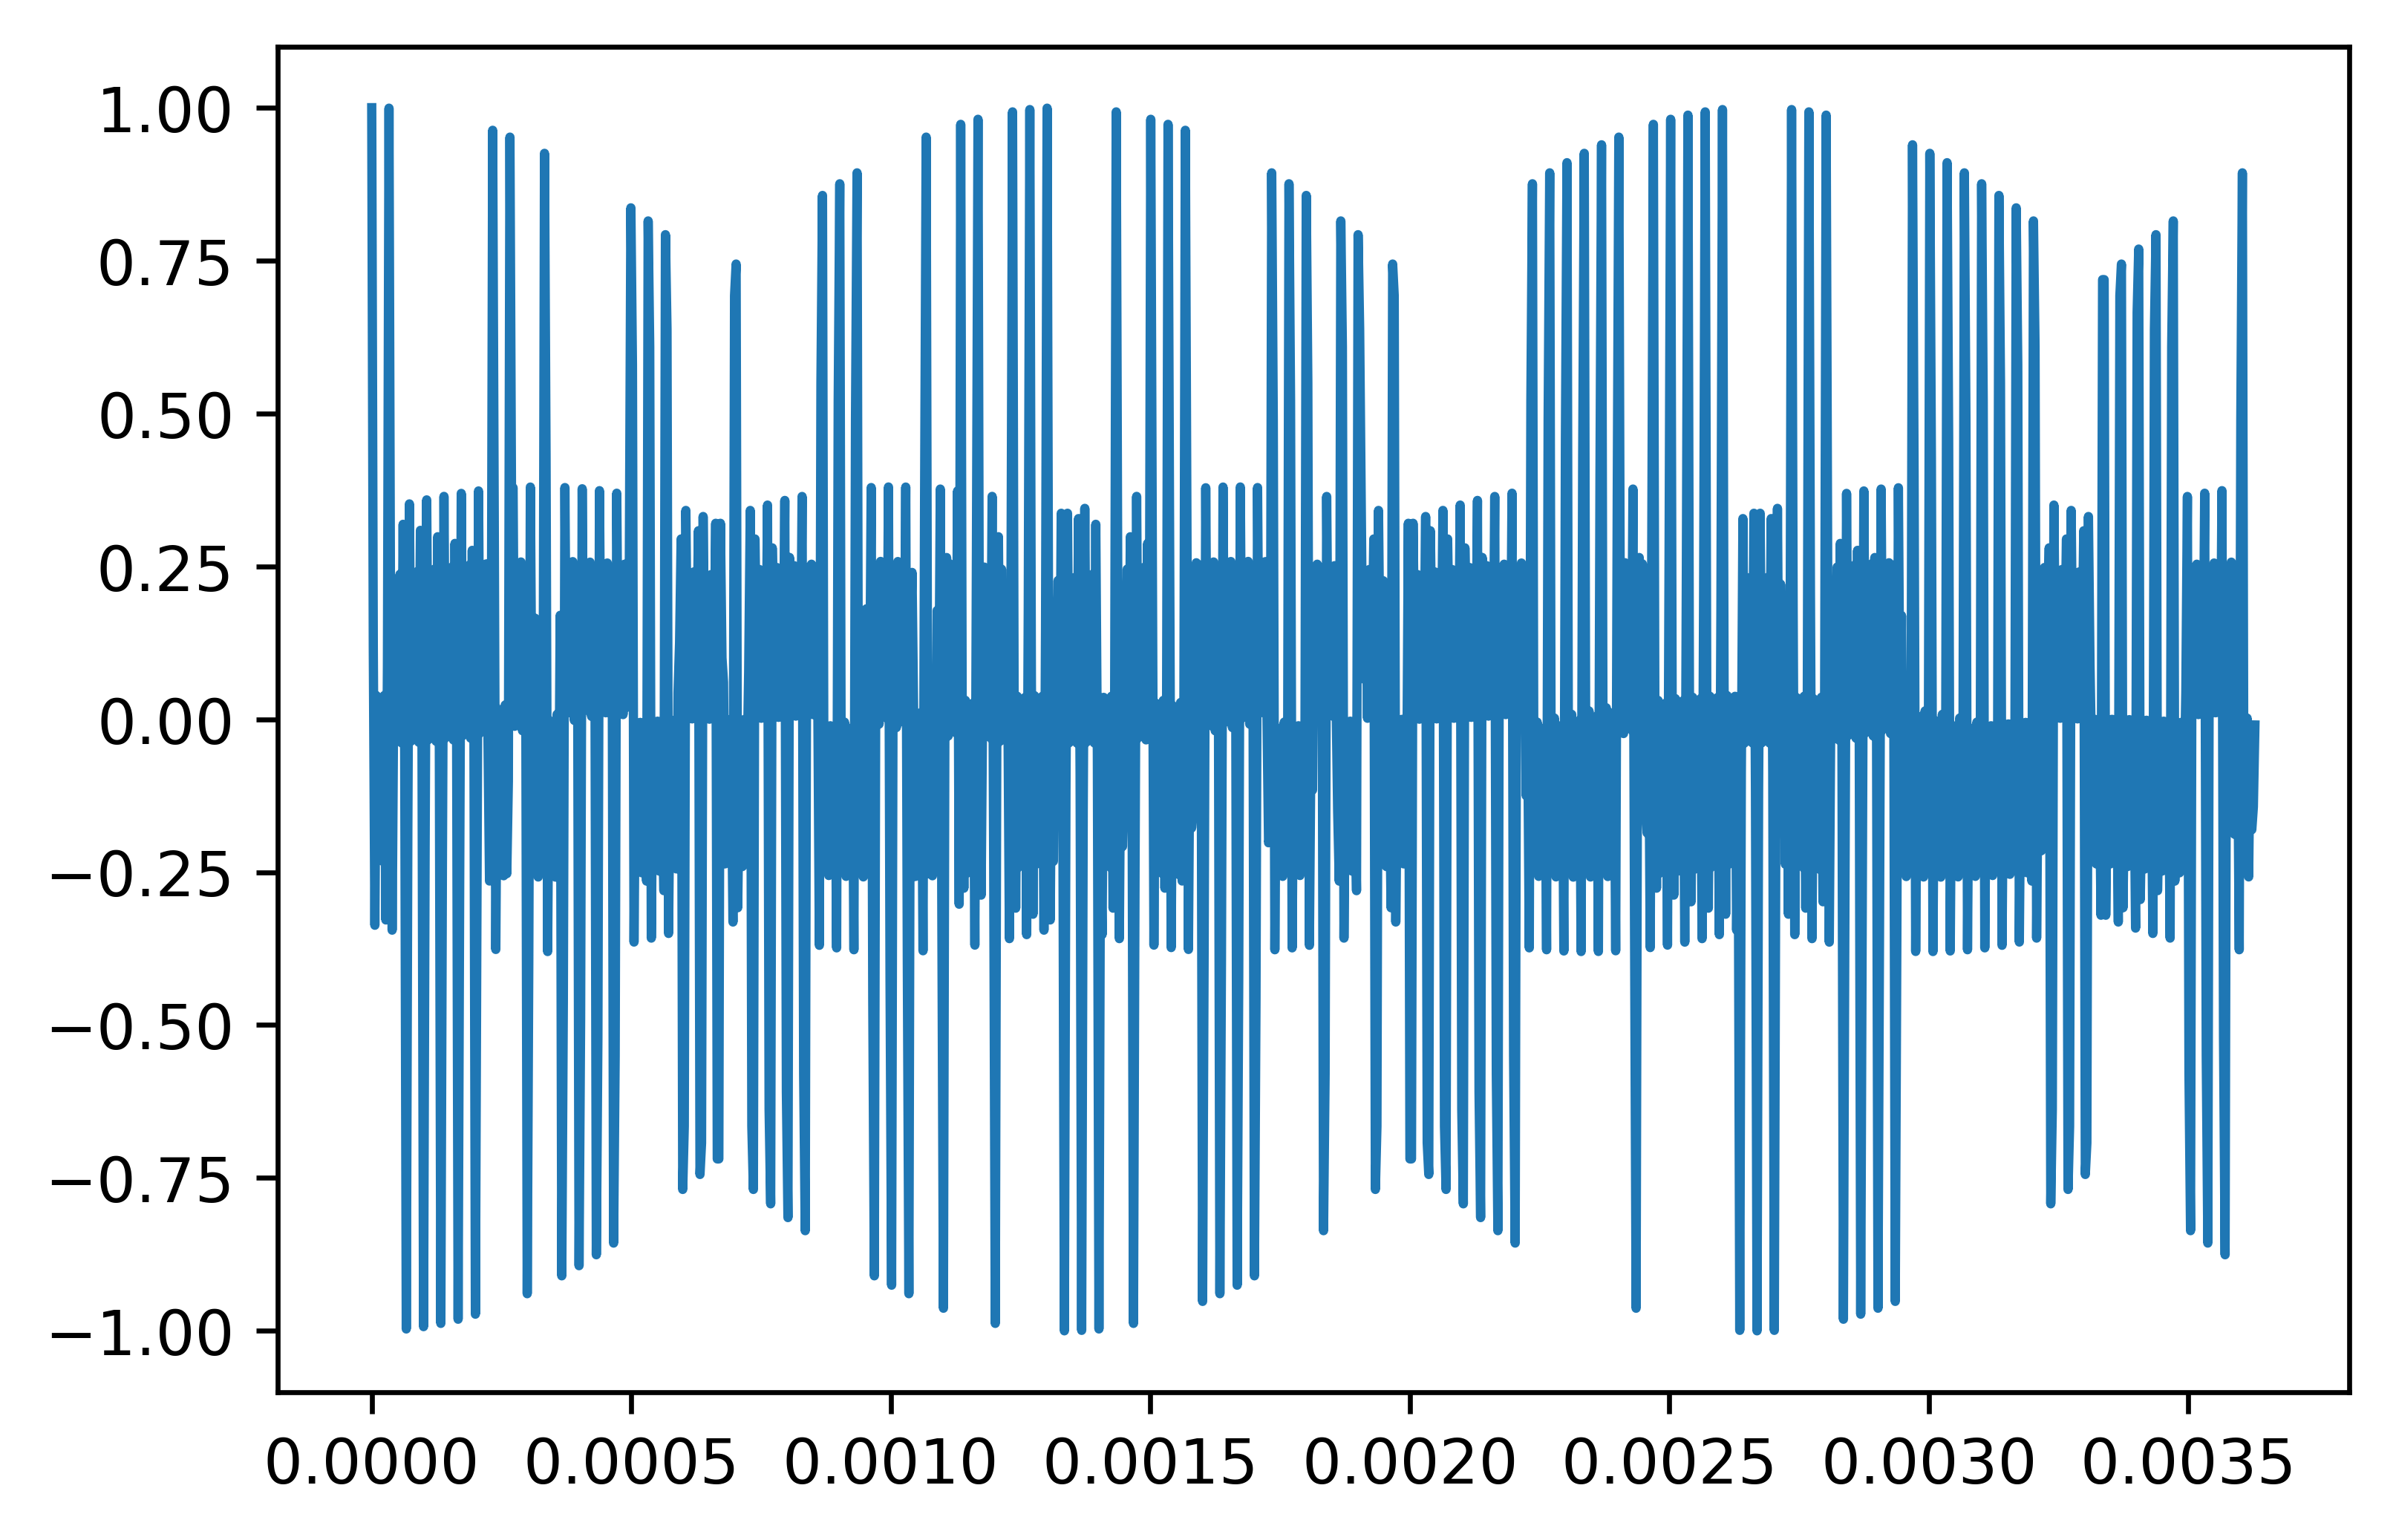

In [24]:
sent_signal = modulator() * signal
plt.plot(t, sent_signal)
plt.show()

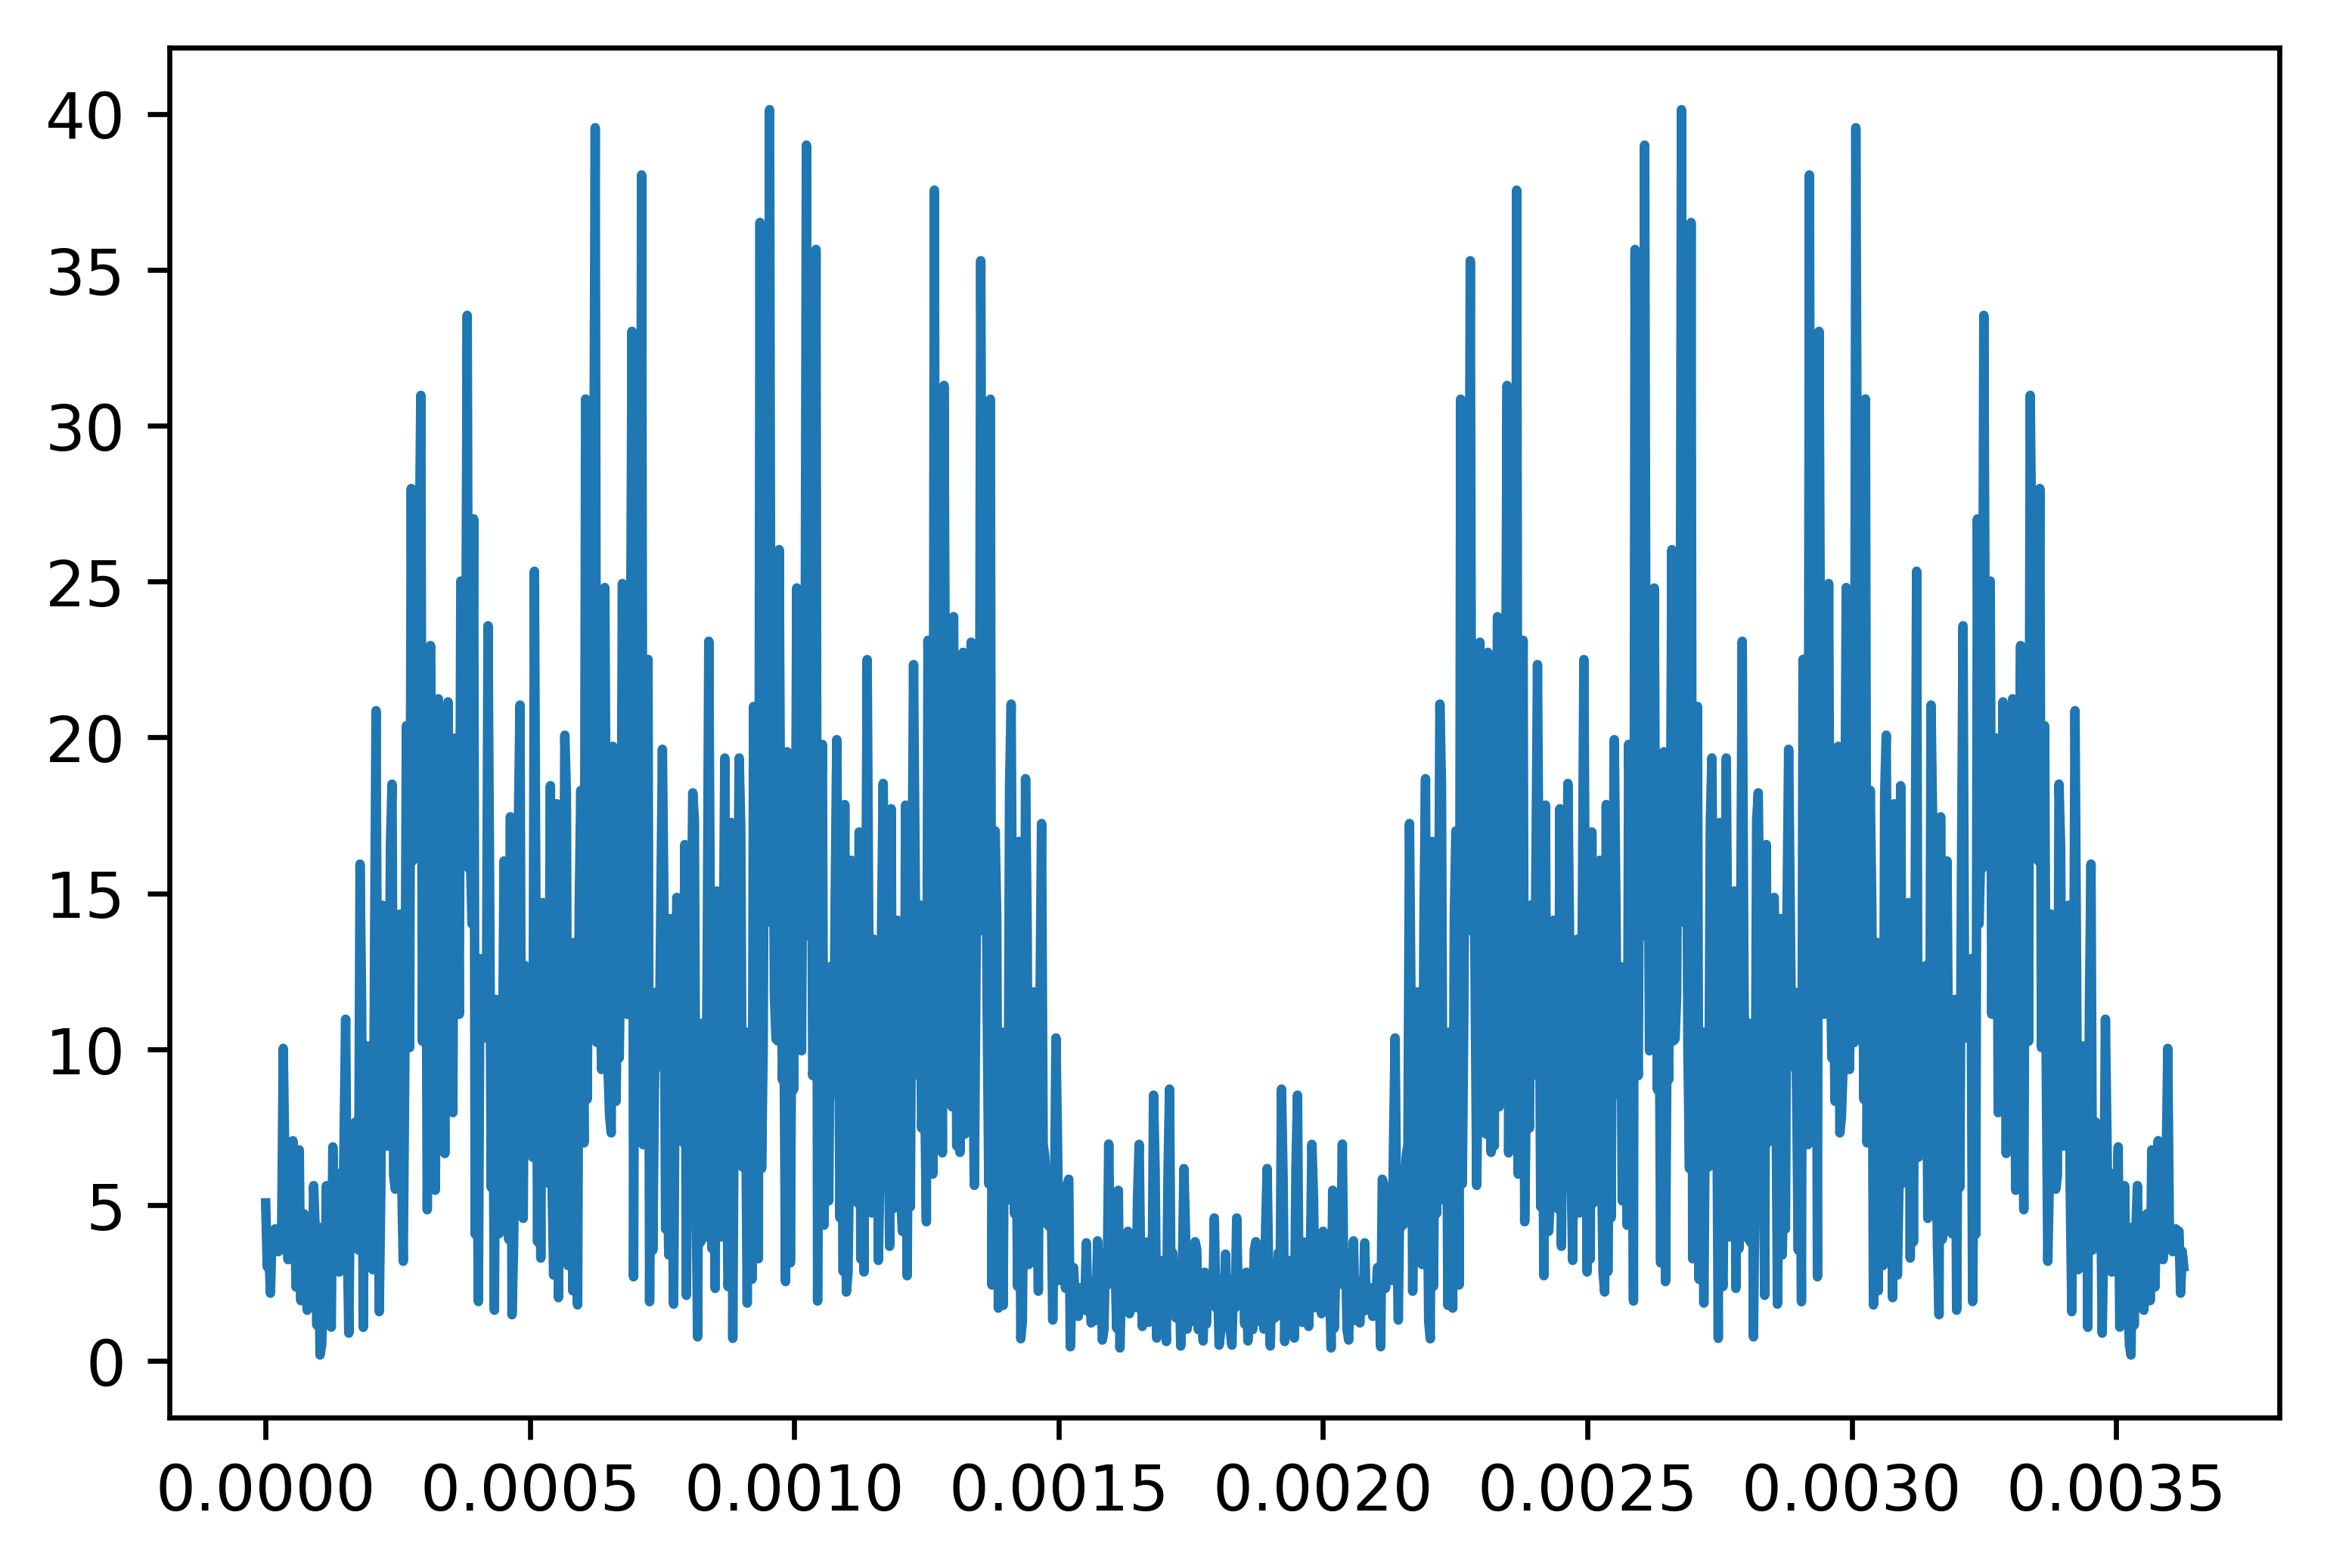

In [25]:
sent_signal_frequencies = fft(sent_signal)
plt.plot(t, abs(sent_signal_frequencies))
plt.show()

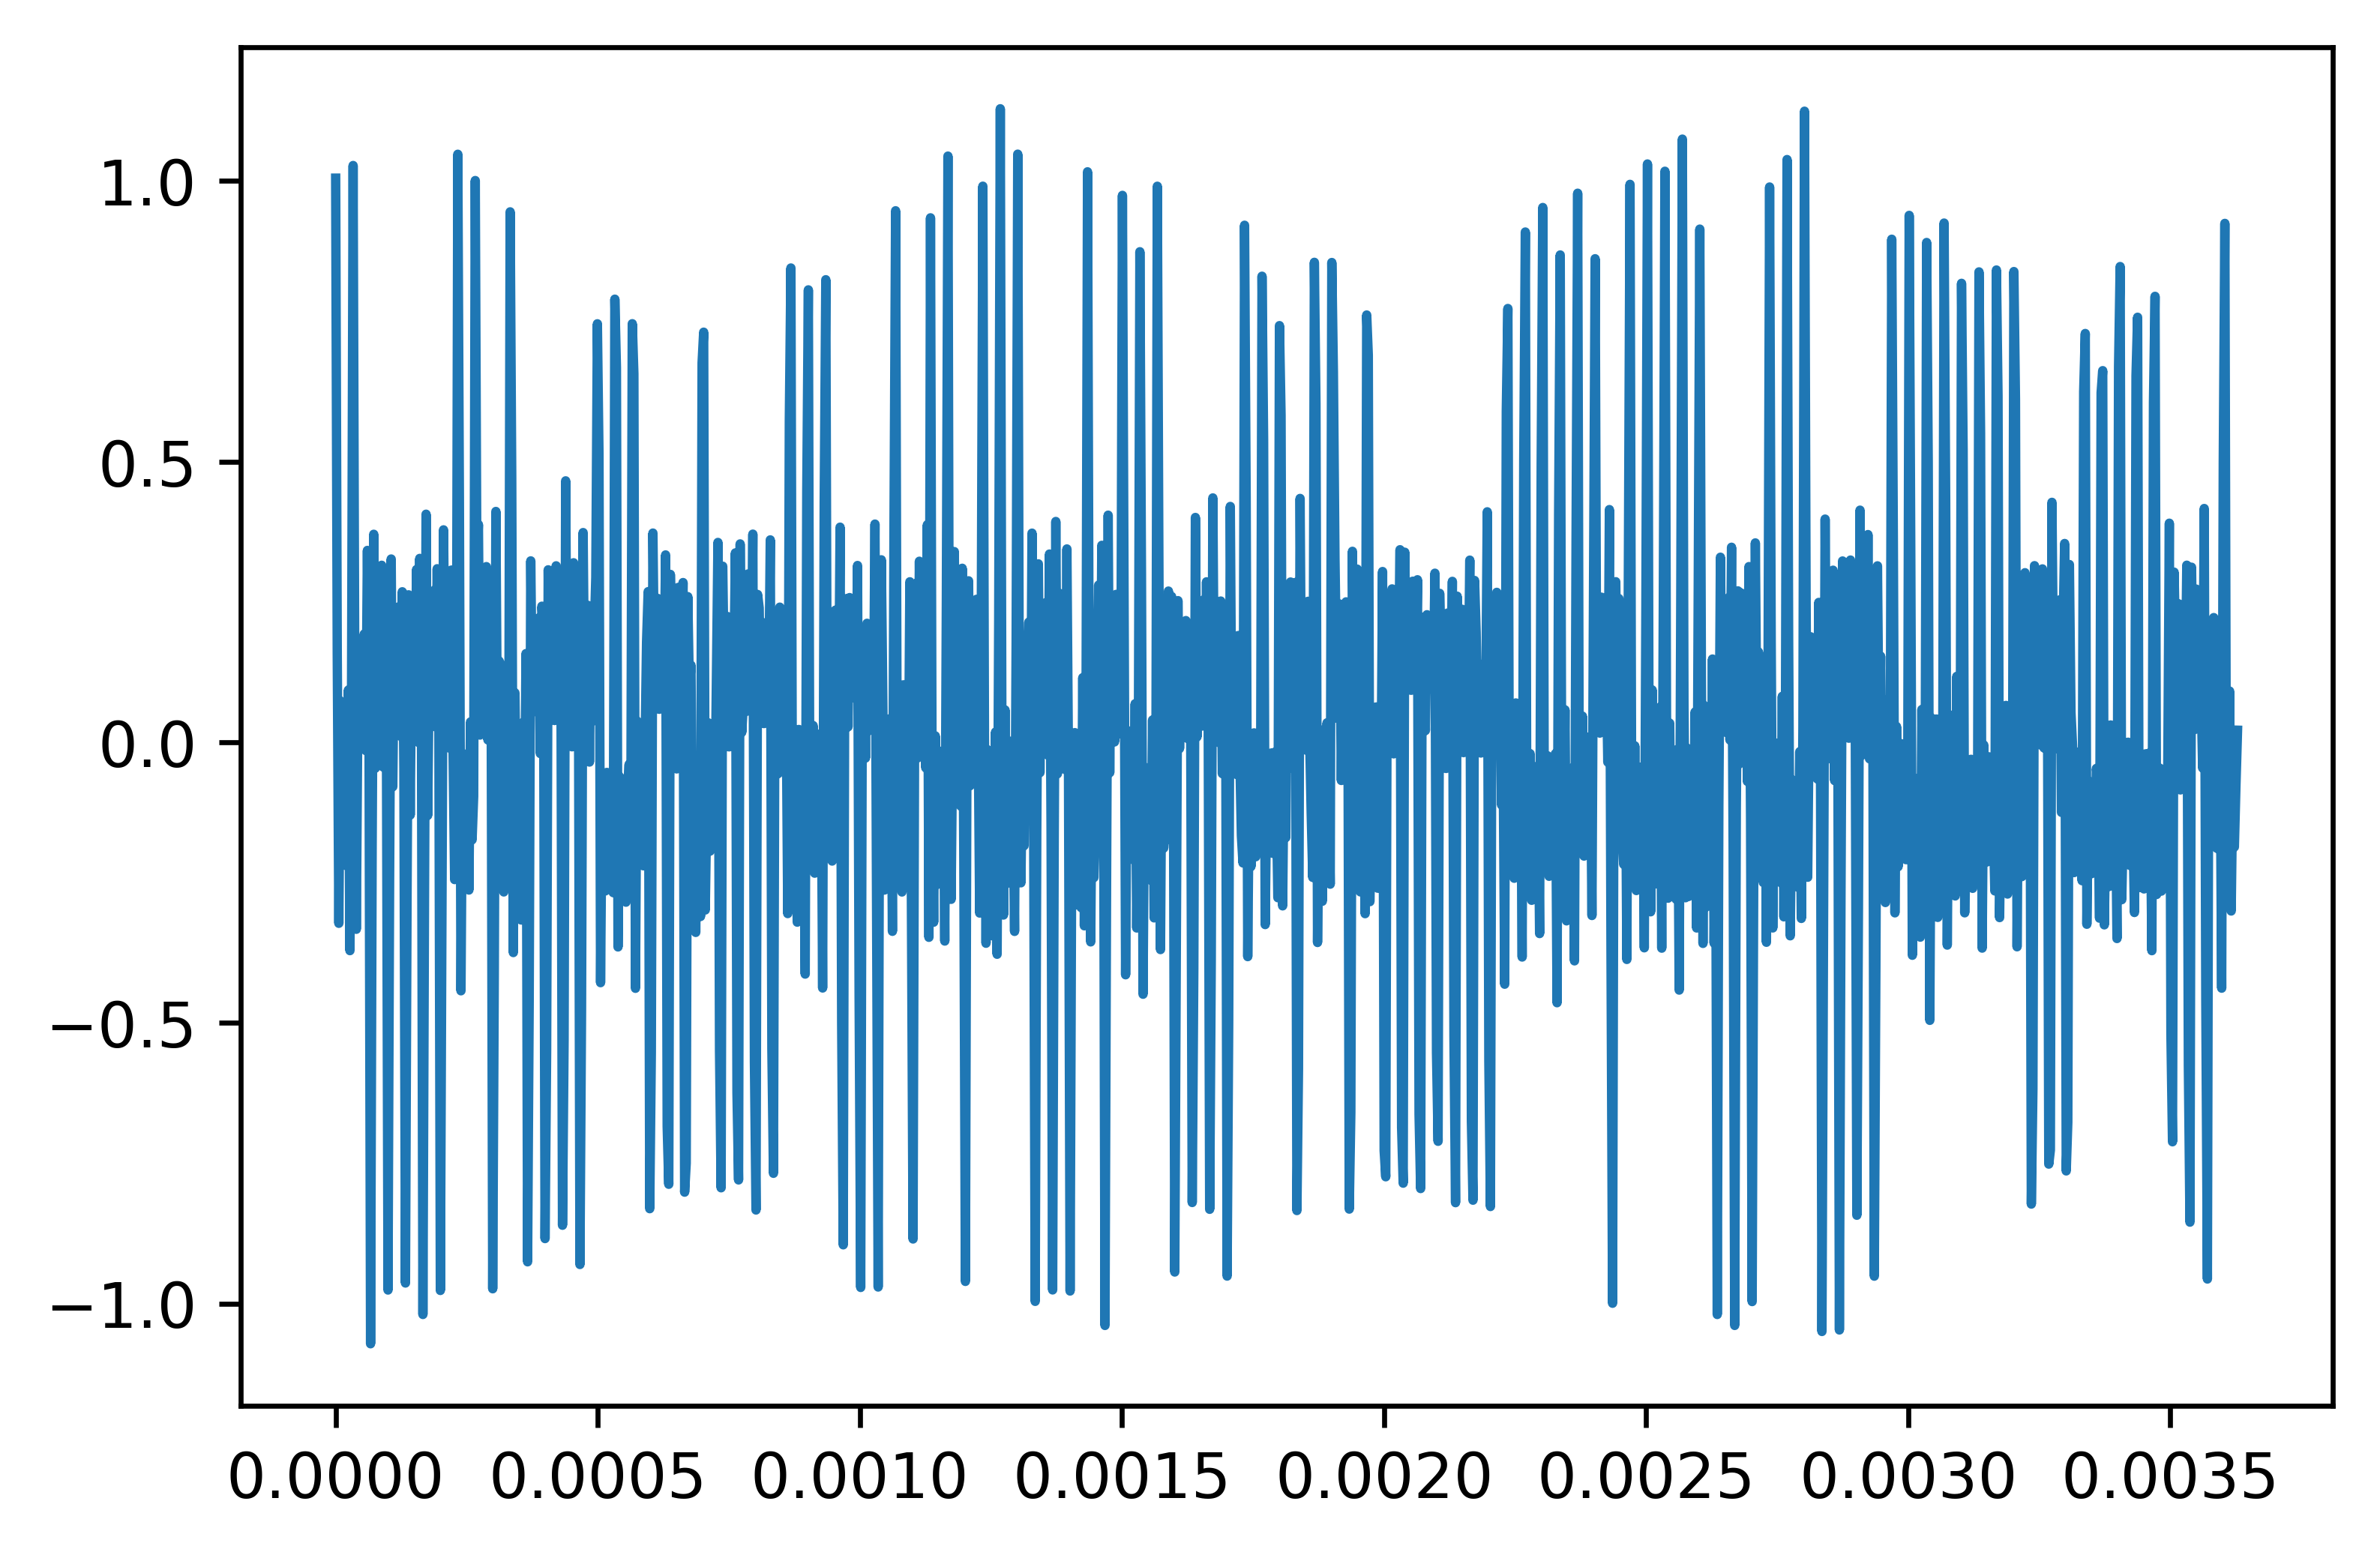

In [26]:
white_noise = normal(0, 0.05, SIGNAL_LENGTH)
noisy_sent_signal = sent_signal+white_noise
plt.plot(t, noisy_sent_signal)
plt.show()

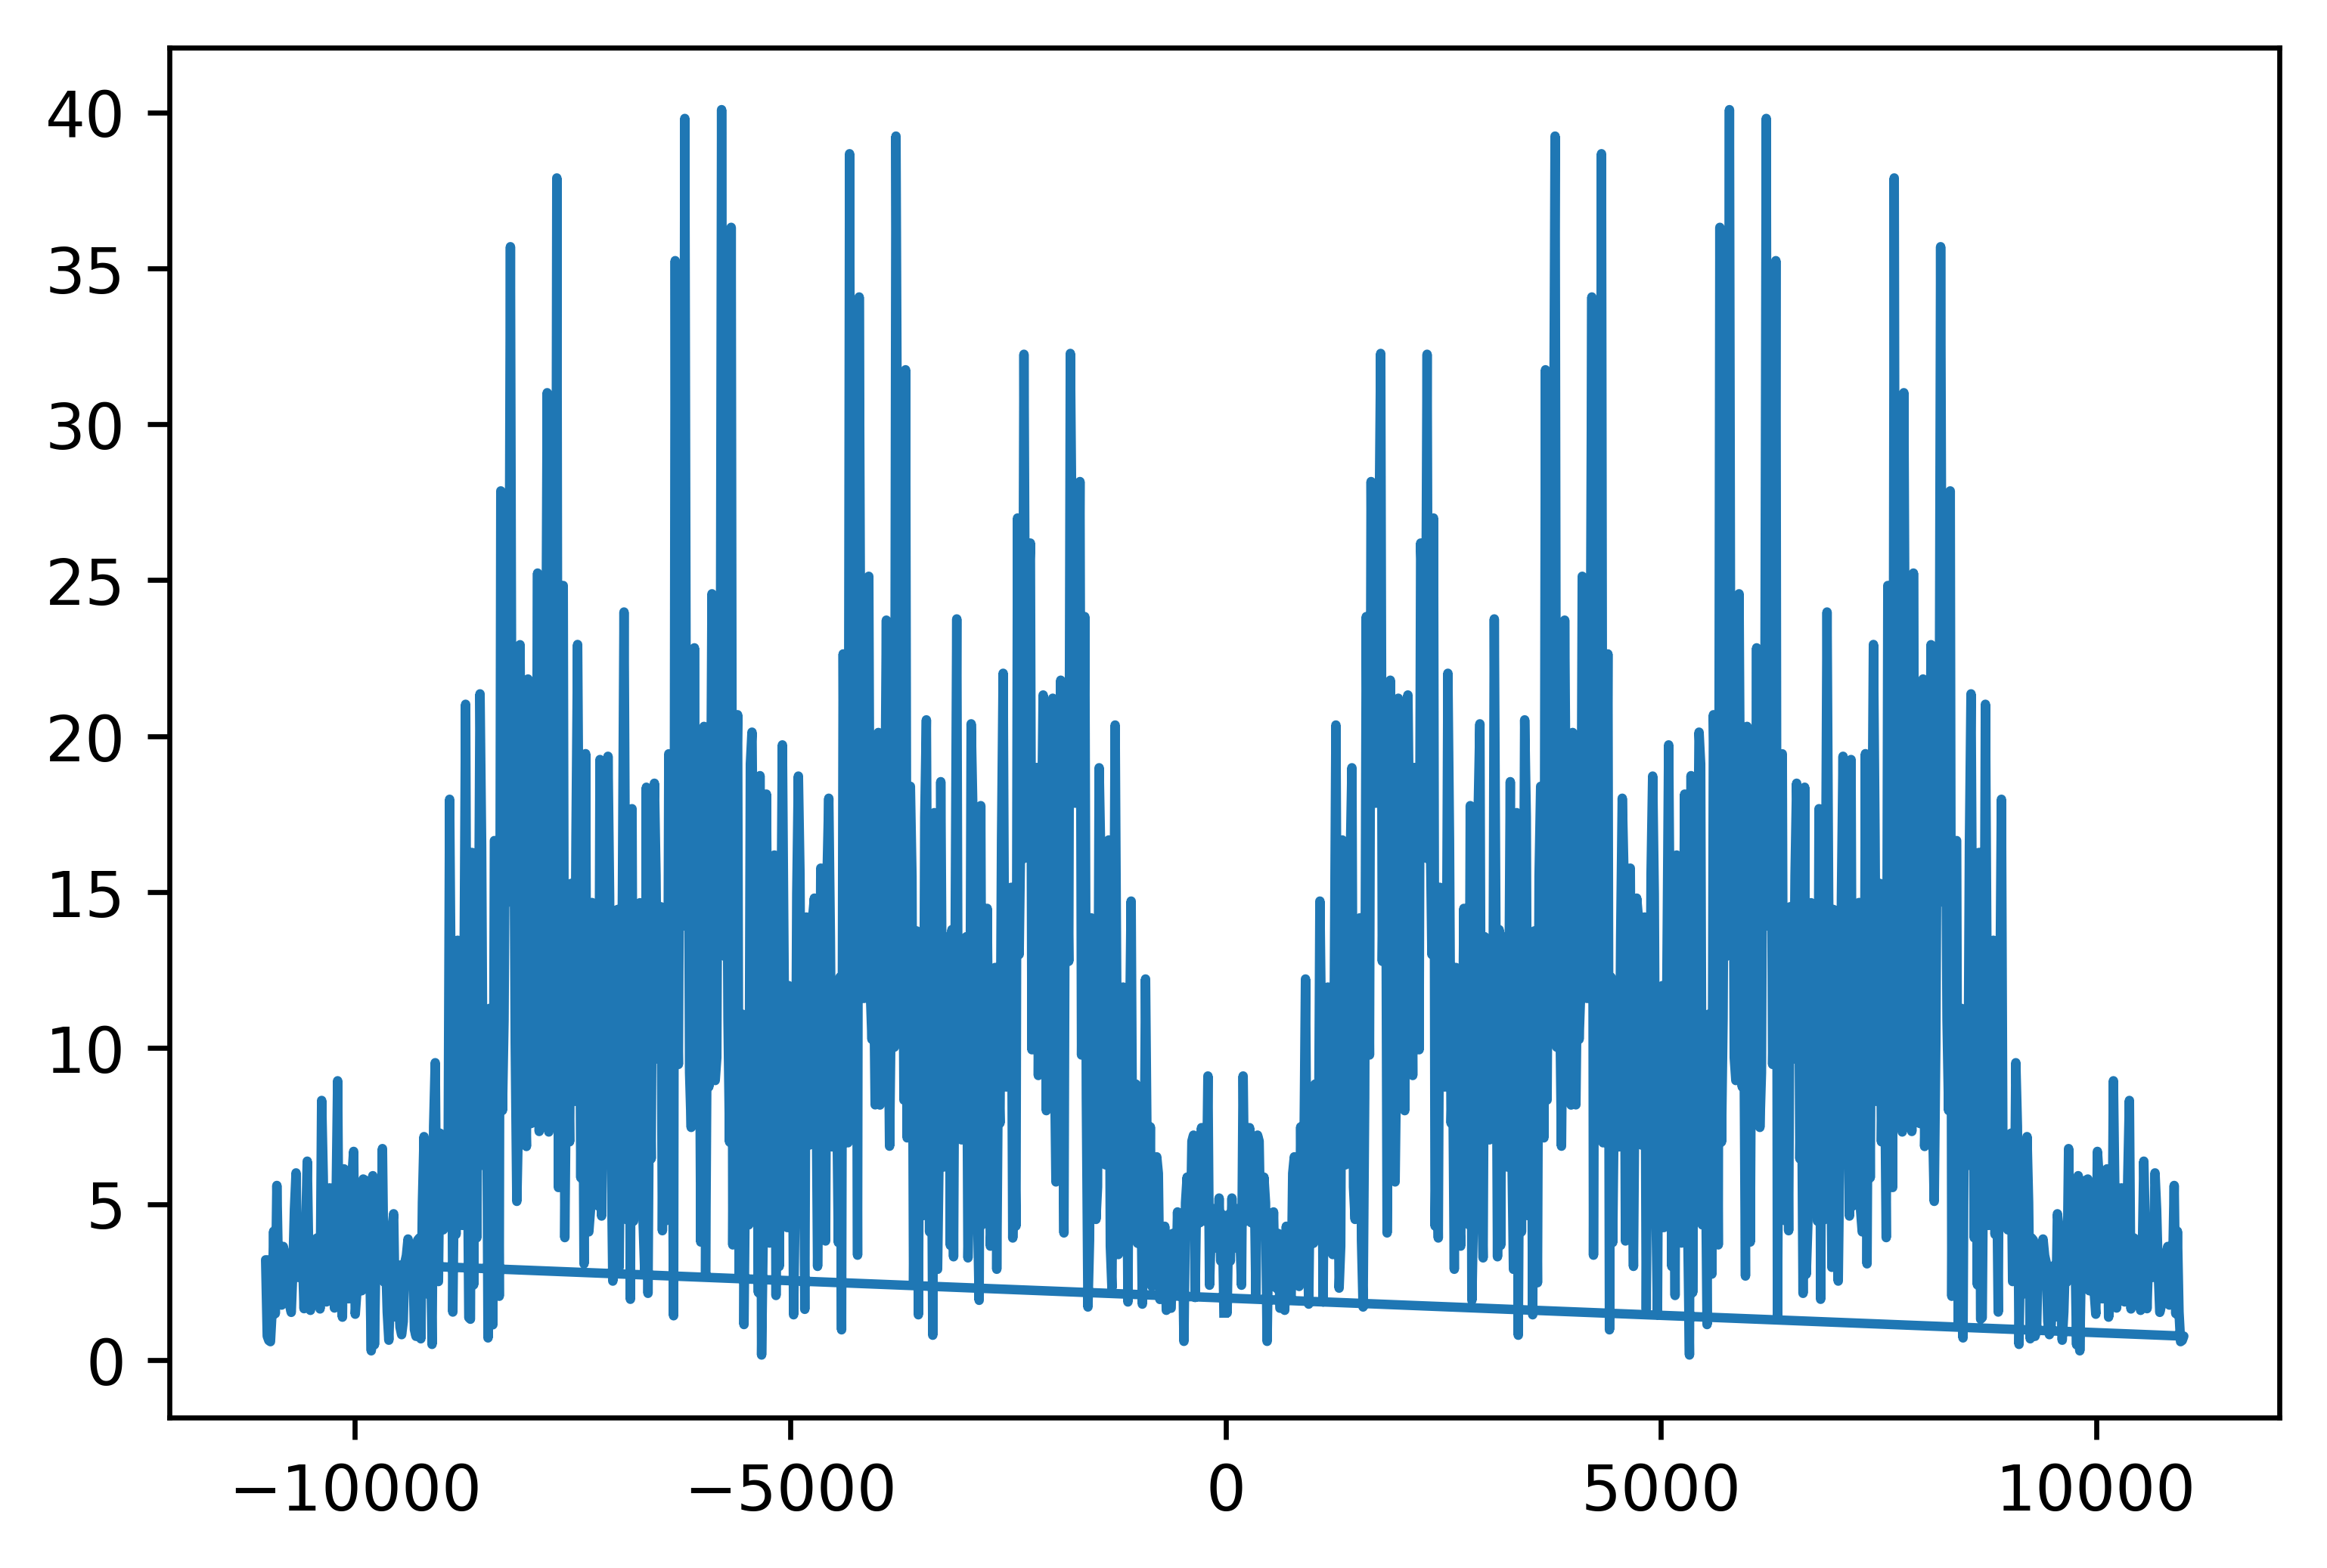

In [27]:
noisy_sent_signal_frequencies = fft(noisy_sent_signal)
plt.plot(f, abs(noisy_sent_signal_frequencies))
plt.show()

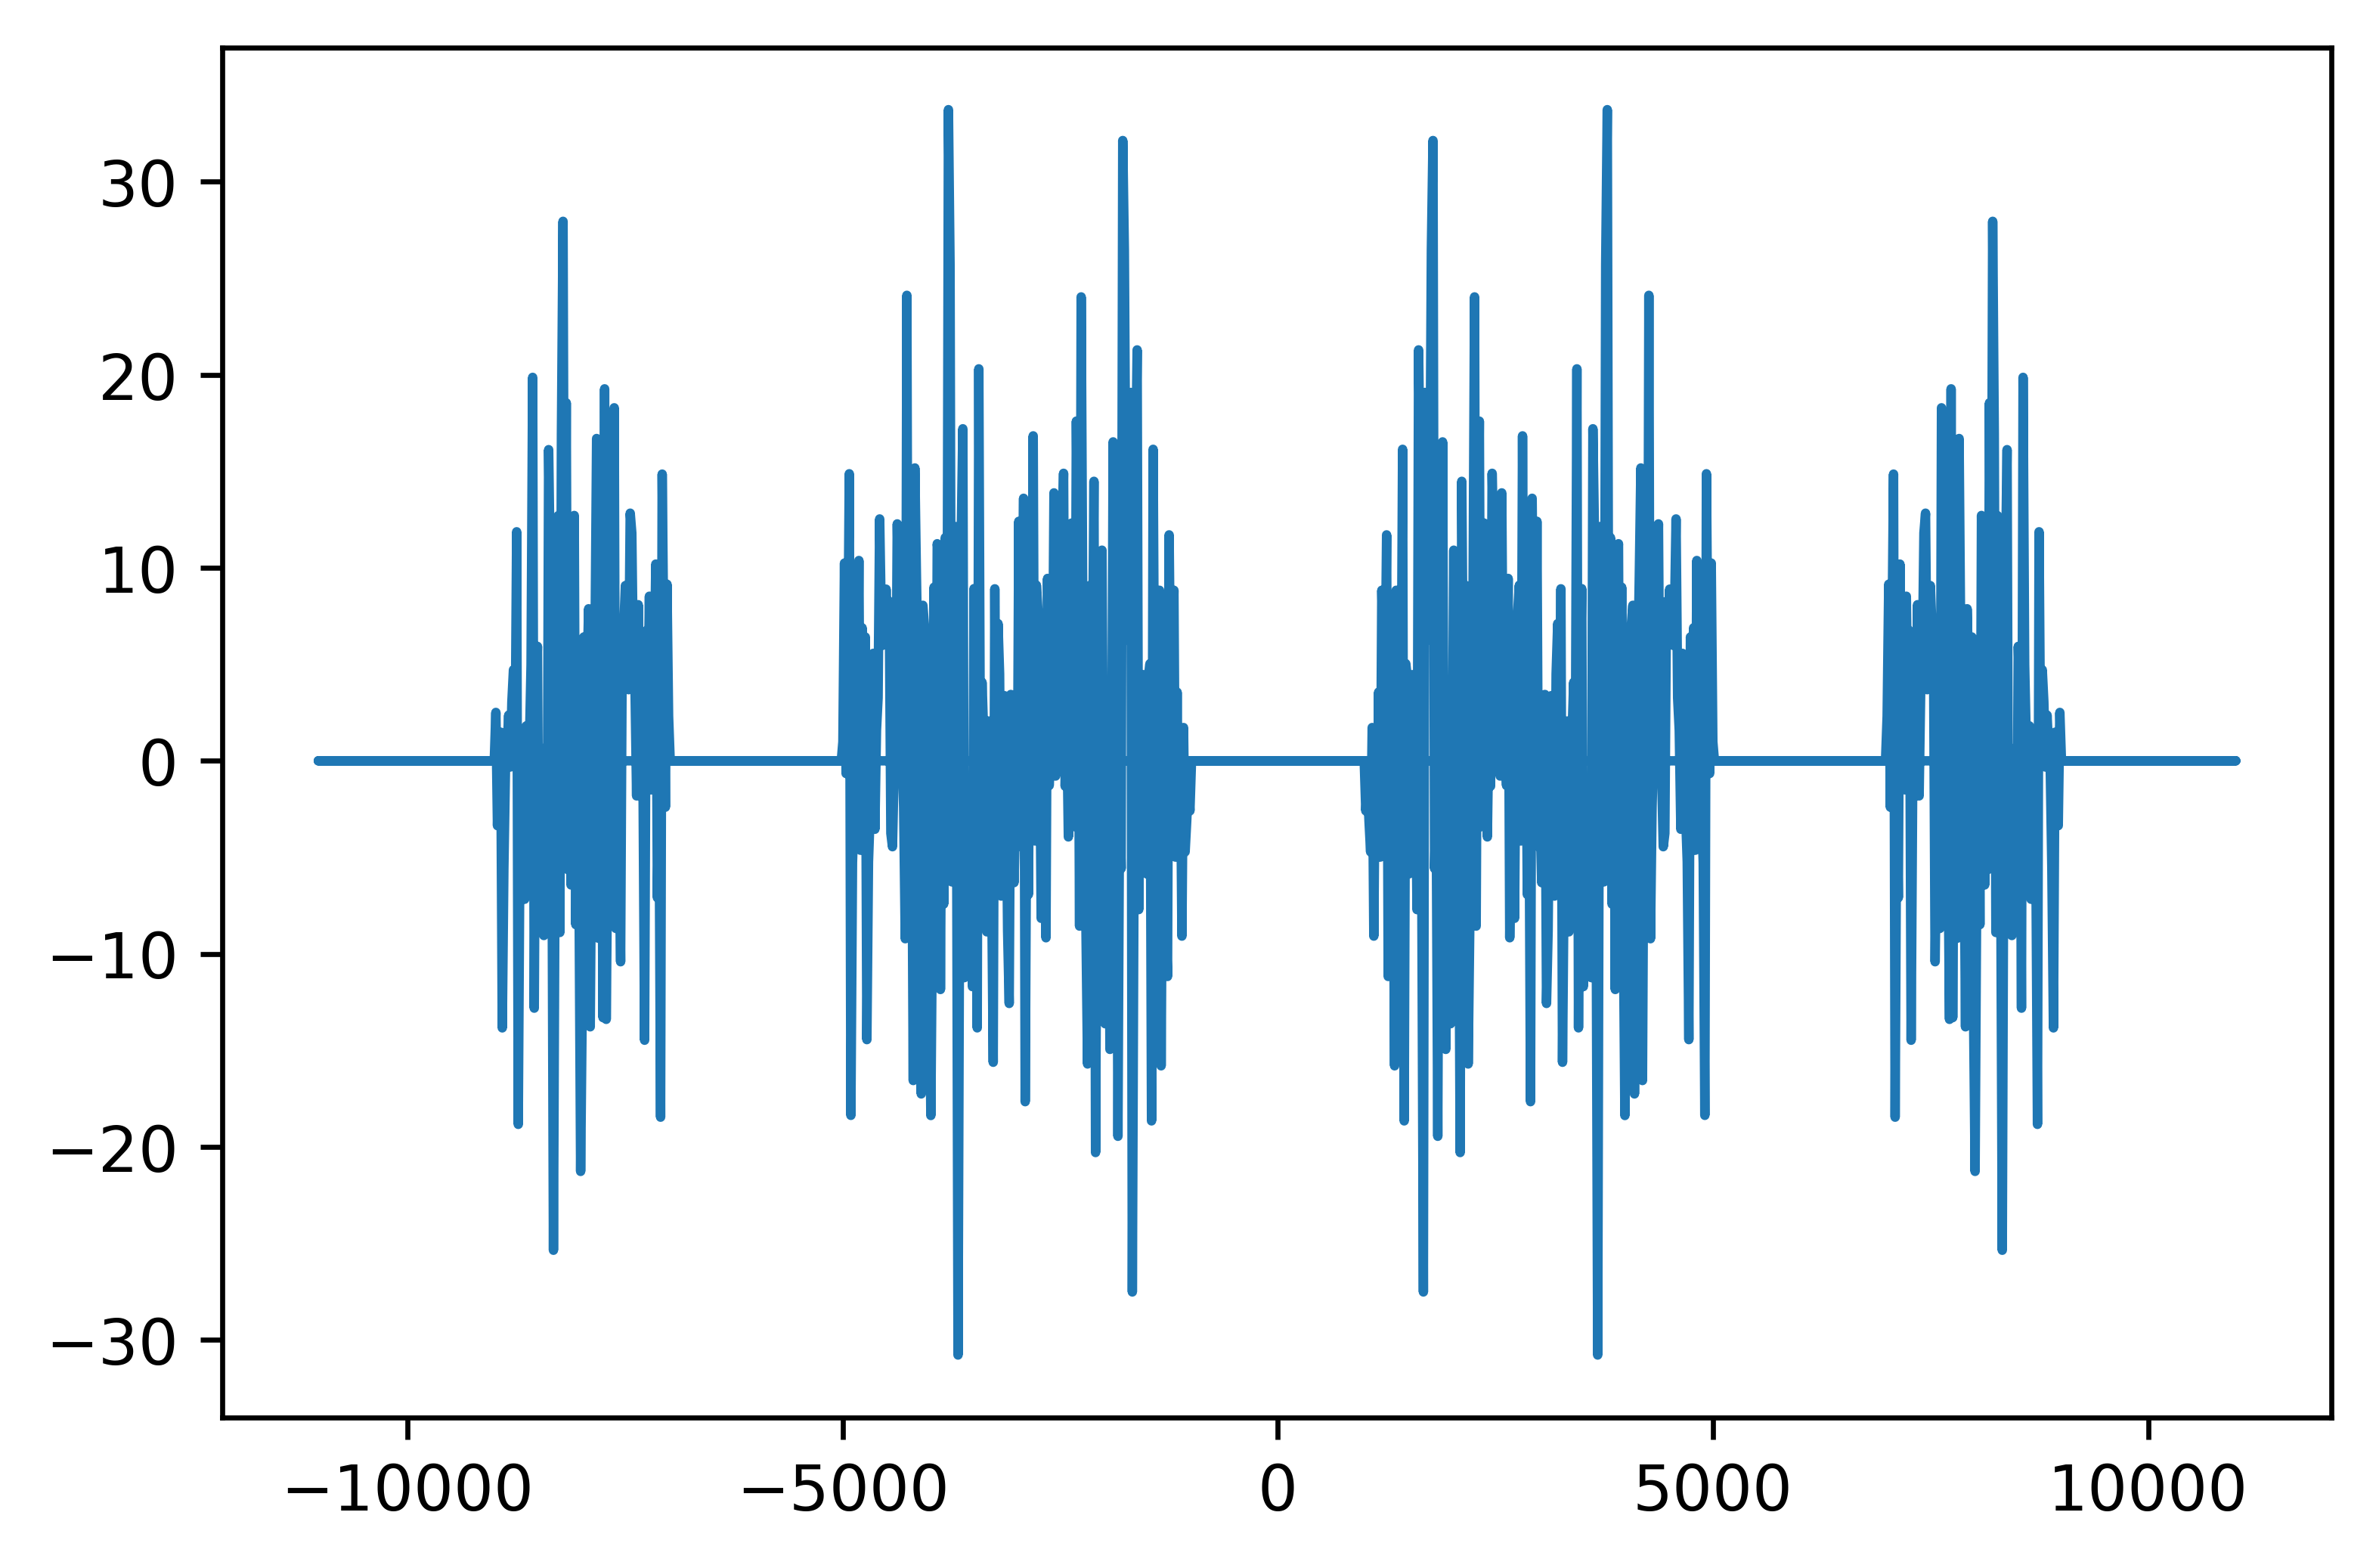

In [28]:
noisy_sent_signal_frequencies_dropped_FREQUENCY_3 = noisy_sent_signal_frequencies * (passband_filter(f, FREQUENCY_1, W) + passband_filter(f, FREQUENCY_2, W) + passband_filter(f, FREQUENCY_4, W))
plt.plot(f, noisy_sent_signal_frequencies_dropped_FREQUENCY_3)
plt.show()

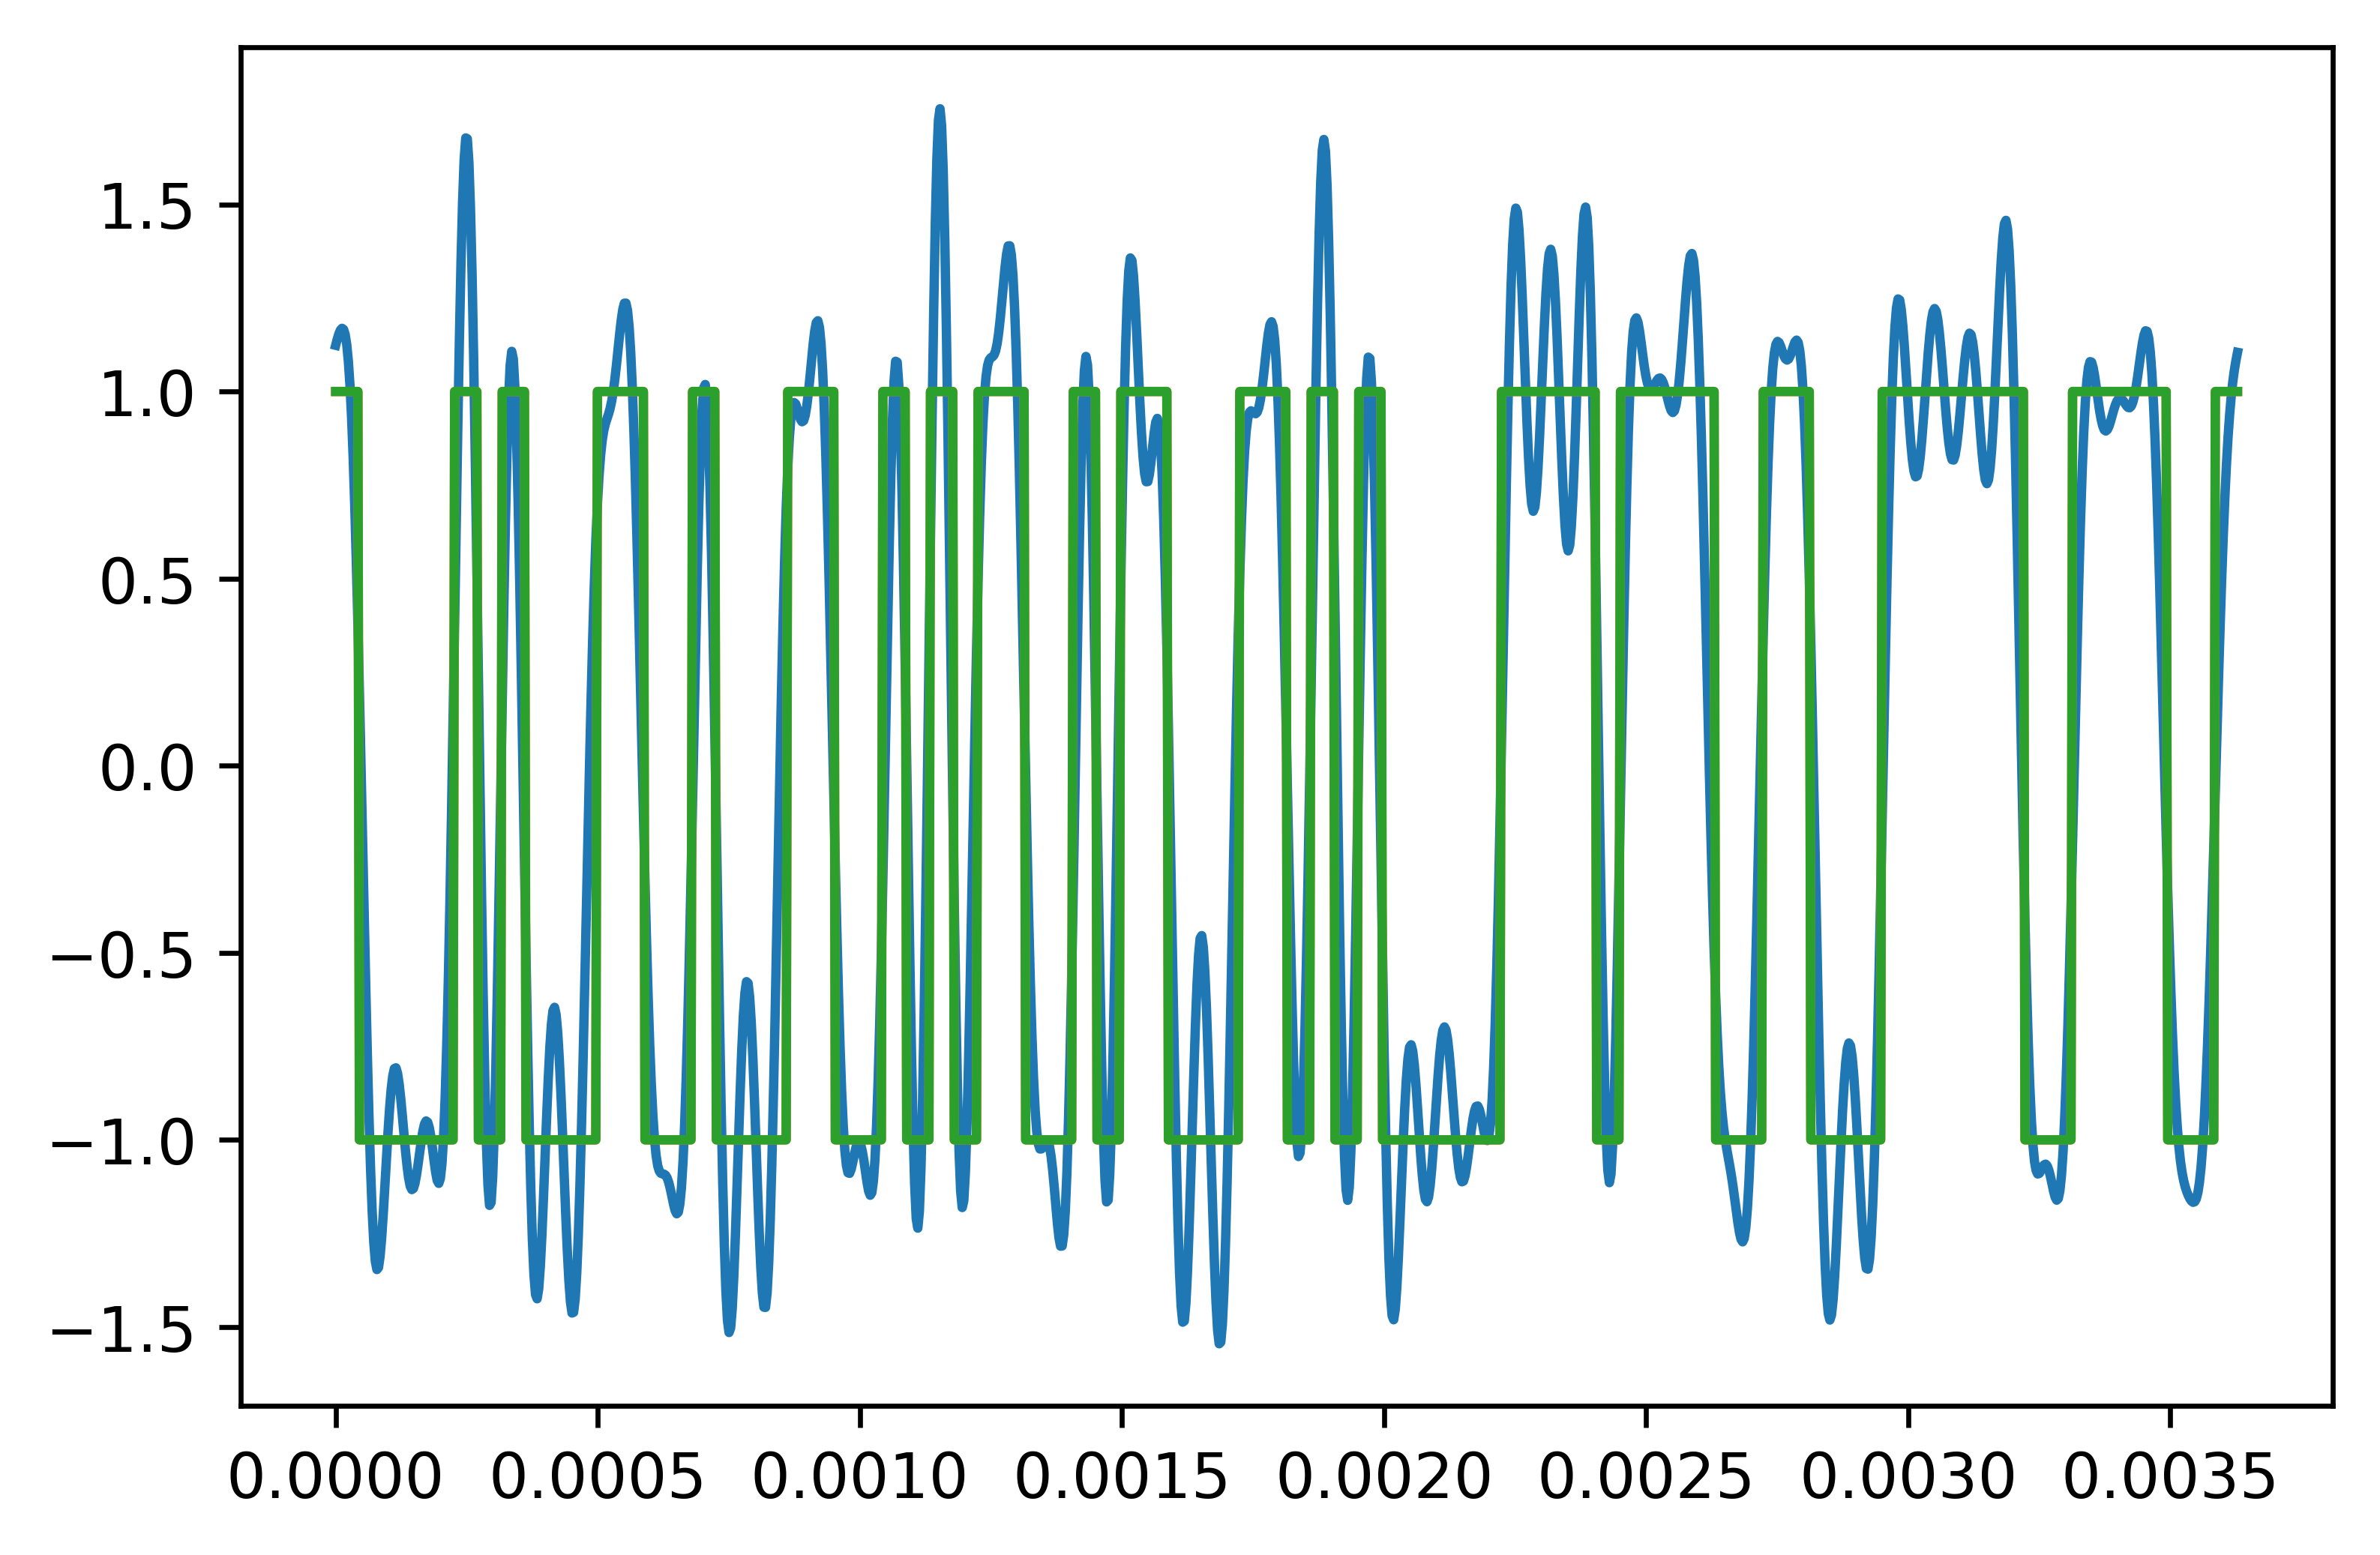

In [30]:
def cos_demodulator(signal, omega):
    signal_frequencies = fft(signal) * passband_filter(f, omega, W)
    demodulated_signal_frequencies = fft(ifft(signal_frequencies) * cos_modulator(omega)) * passband_filter(f, 0, W)
    return ifft(demodulated_signal_frequencies)

def demodulator(signal):
    return 2 * 4/3 * (cos_demodulator(signal, FREQUENCY_1) + cos_demodulator(signal, FREQUENCY_2) + cos_demodulator(signal, FREQUENCY_3) + cos_demodulator(signal, FREQUENCY_4))


a = demodulator(ifft(noisy_sent_signal_frequencies_dropped_FREQUENCY_3))
plt.plot(t, a)
plt.plot(t, signal)
plt.plot(t, [1 if s > 0 else -1 for s in signal])
plt.show()